# ADSG Example: Apollo Mission Architecture

This notebook presents the Apollo mission architecture problem.
The decision-making process for determining the architecture of the Apollo moon missions have been analyzed after the fact, and Simmons[^Simmons2012] has provided it as a formalized optimization problem.

The architecture problem involved choosing the mission architecture:

![optimization loop](https://raw.githubusercontent.com/jbussemaker/adsg-core/main/docs/figures/apollo_mission_decisions.svg)

Additionally, some of the spacecraft architecture and crew assignment is chosen as well:

- Fuel types of the service module and lunar module (if available)
- Crew members (total, and assigned to the lunar module)

For each combination of decisions, a total mass (proxy for mission cost) and success probability can be calculated.
The Apollo problem is implemented in `adsg_core.examples.apollo.ApolloEvaluator`, however here explained in more details.

[^Simmons2012]: Simmons, W. L. (2008). A framework for decision support in systems architecting (Doctoral dissertation, Massachusetts Institute of Technology).

## ADSG

The ADSG models the problem decisions. In total, 9 discrete decisions are involved, however subject to some constraints:

| Decision                     | Options                 | Constraint                              |
|------------------------------|-------------------------|-----------------------------------------|
| EOR (Earth Orbit Rendezvous) | yes, no                 |                                         |
| earthLaunch                  | orbit, direct           | orbit if EOR = yes                      |
| LOR (Lunar Orbit Rendezvous) | yes, no                 | If yes, implies there is a lunar module |
| moonArrival                  | orbit, direct           | orbit if LOR = yes                      |
| moonDeparture                | orbit, direct           | orbit if LOR = yes                      |
| cmCrew (command module)      | 2, 3                    | cmCrew >= lmCrew                        |
| lmCrew (lunar module)        | 0, 1, 2, 3              | 0 if LOR = no, >0 if LOR = yes          |
| smFuel (service module)      | cryogenic, storable     |                                         |
| lmFuel (lunar module)        | NA, cryogenic, storable | NA if LOR = no, != NA if LOR = yes      |

We can model these choices and constraints directly in the ADSG.
For this, we use a custom node type.
In general, when modeling your problem it probably makes sense to define custom node types (inheriting from `NamedNode`) to store problem-specific context.

In [1]:
from adsg_core import BasicADSG, NamedNode, MetricNode, MetricType

# First, we define a custom node type that defines a decision
# variable with some value
class ApolloDecisionVar(NamedNode):

    def __init__(self, decision: str, value):
        self.decision = decision
        self.value = value
        super().__init__(f'{decision}:{value!s}')

    def get_export_title(self) -> str:
        return f'{self.decision} = {self.value}'

### Earth Launch

In [2]:
# Create the ADSG
adsg = BasicADSG()

# Track start nodes
start_nodes = set()

# Define the Earth launch decisions
# If we choose EOR (Earth orbit rendezvous), we have to launch to orbit
# We represent this constraint by first adding the EOR yes/no decision,
# and then adding launch decisions after the no-EOR node

earth_launch = NamedNode('earthLaunch')
start_nodes.add(earth_launch)

# Define the decision values
eor_yes = ApolloDecisionVar('EOR', True)
eor_no = ApolloDecisionVar('EOR', False)
earth_launch_orbit = ApolloDecisionVar('earthLaunch', 'orbit')
earth_launch_direct = ApolloDecisionVar('earthLaunch', 'direct')

# Add EOR [yes/no] choice
adsg.add_selection_choice('EOR', earth_launch, [eor_no, eor_yes])

# Add earthLaunch [orbit/direct] choice, only if EOR=no
adsg.add_selection_choice(
    'earthLaunch', eor_no, [earth_launch_orbit, earth_launch_direct])

# Select earthLaunch=orbit if EOR=yes
adsg.add_edge(eor_yes, earth_launch_orbit)

# Add the system-level metric nodes to the start node
adsg.add_edges([
    (earth_launch,
     MetricNode('mass', direction=-1, type_=MetricType.OBJECTIVE)),
    (earth_launch,
     MetricNode('success', direction=1, type_=MetricType.OBJECTIVE)),
])

adsg = adsg.set_start_nodes(start_nodes)
adsg.render()

### Moon Arrival/Departure

In [3]:
# Define the moon arrival/departure decisions
# If we choose LOR, we have to arrive and depart by orbit
# We represent this constraint by first adding the LOR yes/no decision,
# and then adding arrival/departure decisions after the no-LOR node

moon_arr_dep = NamedNode('moonArrDep')
start_nodes.add(moon_arr_dep)

# Define the decision values
lor_yes = ApolloDecisionVar('LOR', True)
lor_no = ApolloDecisionVar('LOR', False)
moon_arr_orbit = ApolloDecisionVar('moonArrival', 'orbit')
moon_arr_direct = ApolloDecisionVar('moonArrival', 'direct')
moon_dep_orbit = ApolloDecisionVar('moonDeparture', 'orbit')
moon_dep_direct = ApolloDecisionVar('moonDeparture', 'direct')

# Add LOR [yes/no] choice
adsg.add_selection_choice('moonLOR', moon_arr_dep, [lor_no, lor_yes])

# Add moonArr/moonDep [orbit/direct] choices, only if LOR=no
adsg.add_selection_choice(
    'moonArr', lor_no, [moon_arr_orbit, moon_arr_direct])
adsg.add_selection_choice(
    'moonDep', lor_no, [moon_dep_orbit, moon_dep_direct])

# Select orbit arr/dep if LOR=yes
adsg.add_edges([
    (lor_yes, moon_arr_orbit),
    (lor_yes, moon_dep_orbit),
])

adsg = adsg.set_start_nodes(start_nodes)
adsg.render()

### Crew Assignment

In [4]:
# Define crew assignment decision

# Select either 2 or 3 crew in the command module
crew = NamedNode('crew')
start_nodes.add(crew)

crew_2 = ApolloDecisionVar('cmCrew', 2)
crew_3 = ApolloDecisionVar('cmCrew', 3)
adsg.add_selection_choice('crew', crew, [crew_2, crew_3])

# Whether there is a lunar module is determined by whether there is a LOR
# If yes, we select the nr of crew members
# If no, we select 0 crew members
adsg.add_edge(lor_no, ApolloDecisionVar('lmCrew', 0))
lm_crew = [ApolloDecisionVar('lmCrew', n) for n in [1, 2, 3]]
adsg.add_selection_choice('lmCrew', lor_yes, lm_crew)

# Constrain that if we select 2 crew members,
# we cannot select 3 lunar module crew members
adsg.add_incompatibility_constraint([crew_2, lm_crew[-1]])

adsg = adsg.set_start_nodes(start_nodes)
adsg.render()

### Fuel Types

In [5]:
# Define fuel types selections

# Select fuel type for the service module (connected to command module)
service_fuel = NamedNode('smFuel')
start_nodes.add(service_fuel)

sm_fuel_cryogenic = ApolloDecisionVar('smFuel', 'cryogenic')
sm_fuel_storable = ApolloDecisionVar('smFuel', 'storable')
adsg.add_selection_choice(
    'smFuel', service_fuel, [sm_fuel_cryogenic, sm_fuel_storable])

# Select lunar module fuel type if there is a LOR
adsg.add_edge(lor_no, ApolloDecisionVar('lmFuel', 'NA'))
adsg.add_selection_choice('lmFuel', lor_yes, [
    ApolloDecisionVar('lmFuel', 'cryogenic'),
    ApolloDecisionVar('lmFuel', 'storable'),
])

adsg = adsg.set_start_nodes(start_nodes)
adsg.render()

## Optimization Problem

We can now encode the optimization problem and inspect some properties.

In [6]:
from adsg_core import GraphProcessor

gp = GraphProcessor(adsg)
gp.get_statistics()

,n_valid,n_declared,n_discrete,n_dim_cont,n_dim_cont_mean,n_exist,imp_ratio,imp_ratio_comb,imp_ratio_cont,inf_idx,dist_corr,encoder
type,,,,,,,,,,,,
option-decisions,108,768,9,0,0.0,1,7.111111,7.111111,1.0,0.931862,0.0,complete
total-design-space,108,768,9,0,0.0,1,7.111111,7.111111,1.0,0.931862,0.0,complete
total-design-problem,108,768,9,0,0.0,1,7.111111,7.111111,1.0,0.931862,0.0,complete


We observe that there are 108 feasible architectures, which is consistent with the problem definition of Simmons.

By simply taking the Cartesian product of decision variables, there seem to be 768 architectures.
The difference between the two numbers is due to the activation and incompatibility constraints.

It can be quantified using the *imputation ratio*, which in this case is:
`imp_ratio = n_declared / n_valid = 768 / 108 = 7.11`

### Evaluation Function

The evaluation function should interpret the ADSG and provide a dictionary with the following format:
```python
decision_values = {
    'EOR': False,
    'earthLaunch': 'direct',
    'LOR': False,
    'moonArrival': 'direct',
    'moonDeparture': 'direct',
    'lmCrew': 0,
    'lmFuel': 'NA',
}
```

This dictionary then provides the input to the problem-specific calculations, in this case two functions where the implementation is already available.

The evaluation function is provided by implementing the `_evaluate` function of an extended `ADSGEvaluator` class.

In [9]:
from typing import List, Dict
from adsg_core import ADSGEvaluator, ADSGType
from adsg_core.examples.apollo import ApolloEvaluator

class ExampleApolloEvaluator(ADSGEvaluator):

    def _evaluate(self, adsg_inst: ADSGType, metric_nodes: List[MetricNode])\
            -> Dict[MetricNode, float]:
        # We can construct the decision table by simply looping over all
        # selected decision variable nodes
        decision_values = {}
        dv_node: ApolloDecisionVar
        for dv_node in adsg_inst.get_nodes_by_type(ApolloDecisionVar):
            decision_values[dv_node.decision] = dv_node.value

        # Calculate metrics: the outputs of this function should be a dict
        # mapping requested metric nodes to values
        results = {}
        for metric_node in metric_nodes:
            if metric_node.name == 'mass':
                results[metric_node] = \
                    ApolloEvaluator.eval_mass(decision_values)
            elif metric_node.name == 'success':
                results[metric_node] = \
                    ApolloEvaluator.eval_success_probability(decision_values)

        return results

In [17]:
# Instantiate the evaluator
evaluator = ExampleApolloEvaluator(adsg)

# Test some architectures
for i in range(5):
    # Generate random architecture
    dv = evaluator.get_random_design_vector()
    graph, dv_corr, is_active = evaluator.get_graph(dv)

    # Evaluate it
    obj, con = evaluator.evaluate(graph)
    print(f'Architecture {i+1}: {list(dv_corr)}')
    print(f'  Objectives: {list(obj)}')

Architecture 1: [1, 1, 0, 0, 0, 0, 0, 0, 1]
  Objectives: [152804.621121641, 0.6825444271593749]
Architecture 2: [1, 1, 0, 1, 0, 0, 0, 0, 0]
  Objectives: [285573.9286719209, 0.8379855]
Architecture 3: [0, 0, 0, 1, 0, 0, 0, 1, 0]
  Objectives: [207690.1299432152, 0.829521]
Architecture 4: [0, 0, 0, 1, 0, 0, 0, 0, 0]
  Objectives: [207690.1299432152, 0.8644482]
Architecture 5: [0, 1, 1, 1, 1, 0, 0, 0, 0]
  Objectives: [95198.64480119203, 0.6064005890249999]


### Results

Since there are only 108 architectures, we can evaluate all and plot their performances.

In [11]:
# Get all valid design vectors
x_all, _ = evaluator.get_all_discrete_x()

# Loop over them
masses = []
success_probabilities = []
for x in x_all:
    # Get associated ADSG instance
    graph, _, _ = evaluator.get_graph(x)

    # Evaluate
    obj, _ = evaluator.evaluate(graph)
    masses.append(obj[0])
    success_probabilities.append(obj[1])

In [15]:
# Get points in the Pareto front
import numpy as np
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting

masses = np.array(masses)
success_probabilities = np.array(success_probabilities)

i_pf = NonDominatedSorting().do(
    np.column_stack([masses, -success_probabilities]),
    only_non_dominated_front=True)
print(f'{len(i_pf)} of {len(masses)} points in Pareto front')

6 of 108 points in Pareto front


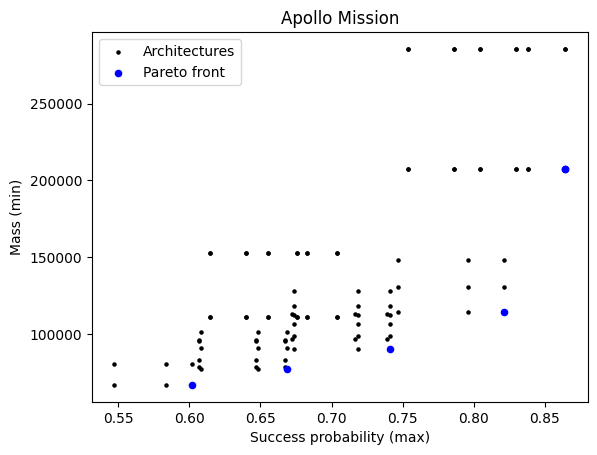

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(), plt.title('Apollo Mission')
plt.scatter(success_probabilities, masses, s=5, c='k', label='Architectures')
plt.scatter(success_probabilities[i_pf], masses[i_pf], s=20, c='b', label='Pareto front')
plt.xlabel('Success probability (max)'), plt.ylabel('Mass (min)')
plt.legend()
plt.show()

As typical of architecture optimization problems, there is a clear trade-off:
increasing the success probability comes with an increase in mass (and therefore cost).

The trade-off is seen by a Pareto front: the front of points where no point exists that is better in *all* objectives.
In this case there are 6 points in the Pareto front, with various mass vs success probability values.